# Bear classifier


See a deployed app [here](https://huggingface.co/spaces/nesaboz/bear_classifier).

There will be two parts to it:\
- first part generates a model\
- second part deploys it as an app on HuggingFace (see [code](https://huggingface.co/spaces/nesaboz/bear_classifier))

In [ ]:
import fastbook
fastbook.setup_book()
from tqdm import tqdm
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
results = search_images_ddg('grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

200

In [1]:
#| hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [ ]:
dest = 'bear_images/grizzly.jpg'
download_url(ims[0], dest)

Path('bear_images/grizzly.jpg')

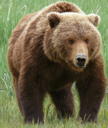

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bear_images')

In [ ]:
if not path.exists():
    path.mkdir()

In [ ]:
for o in tqdm(bear_types):
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls=results)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:50<00:00, 25.04s/it]


In [ ]:
fns = get_image_files(path)
fns

(#578) [Path('bear_images/grizzly/e1a38b7a-5ad4-4070-b27d-7991e67ffbf1.jpg'),Path('bear_images/grizzly/8af6b4cd-7146-4401-8201-3c69b630bb9c.jpg'),Path('bear_images/grizzly/5afcf7a1-0ff0-4c7f-b012-fa5f2fea5a2c.jpg'),Path('bear_images/grizzly/0d7a2b60-9867-4a6f-a785-1b0877b5949a.jpg'),Path('bear_images/grizzly/7977441d-8f9e-4a87-9fc1-1bdaa54151c5.jpg'),Path('bear_images/grizzly/b2e96643-4ea1-49b6-bd77-dac698a9e333.jpg'),Path('bear_images/grizzly/c6be2eea-8fc4-4678-8b35-ba2b5ca20ea2.jpg'),Path('bear_images/grizzly/83500b29-961d-4273-8249-164e123232c7.jpg'),Path('bear_images/grizzly/96ad8b99-4570-4210-85f1-7a664efabe8a.jpg'),Path('bear_images/grizzly/6e24cf29-dae3-41d4-9152-afc34e622236.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#9) [Path('bear_images/grizzly/3216c80f-8f83-4bf9-84ff-811da170b8c7.jpg'),Path('bear_images/grizzly/7cd788f0-f6a4-495b-9745-5a4972c1b9de.jpg'),Path('bear_images/black/165f5c5c-d9c9-4113-b863-1e62ef2ce219.jpg'),Path('bear_images/black/7b7e11b1-a71a-4e93-b10f-7b6d72d62330.jpg'),Path('bear_images/black/70d2b973-2b84-464d-b9d9-f077af0f7451.jpg'),Path('bear_images/black/268676a1-dd6c-4cd8-b15c-cb999a38e857.jpg'),Path('bear_images/black/a22e8eee-25c0-4e0f-b954-768d2be32dfb.jpg'),Path('bear_images/black/90d38027-558e-49cd-ba26-934c80b4e593.jpg'),Path('bear_images/teddy/d09b9bcd-728f-429b-9506-06d4b59a5b41.jpg')]

In [ ]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

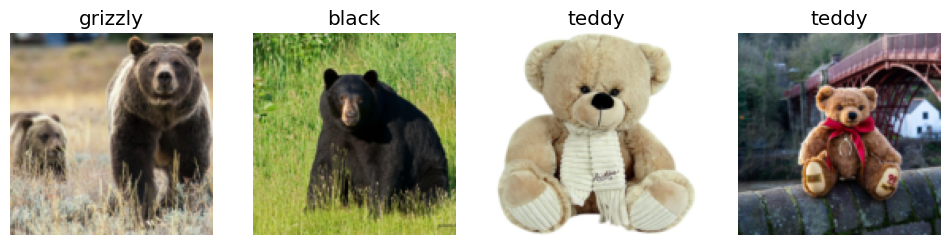

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

## Training Your Model, and Using It to Clean Your Data

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [ ]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.027743,0.179141,0.062500,01:22


epoch,train_loss,valid_loss,error_rate,time
0,0.114028,0.170333,0.026786,01:35
1,0.096802,0.224060,0.026786,01:28
2,0.081567,0.242517,0.026786,01:22
3,0.065939,0.244289,0.026786,01:20


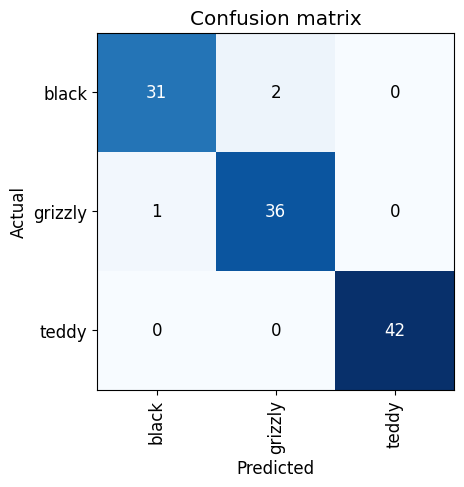

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

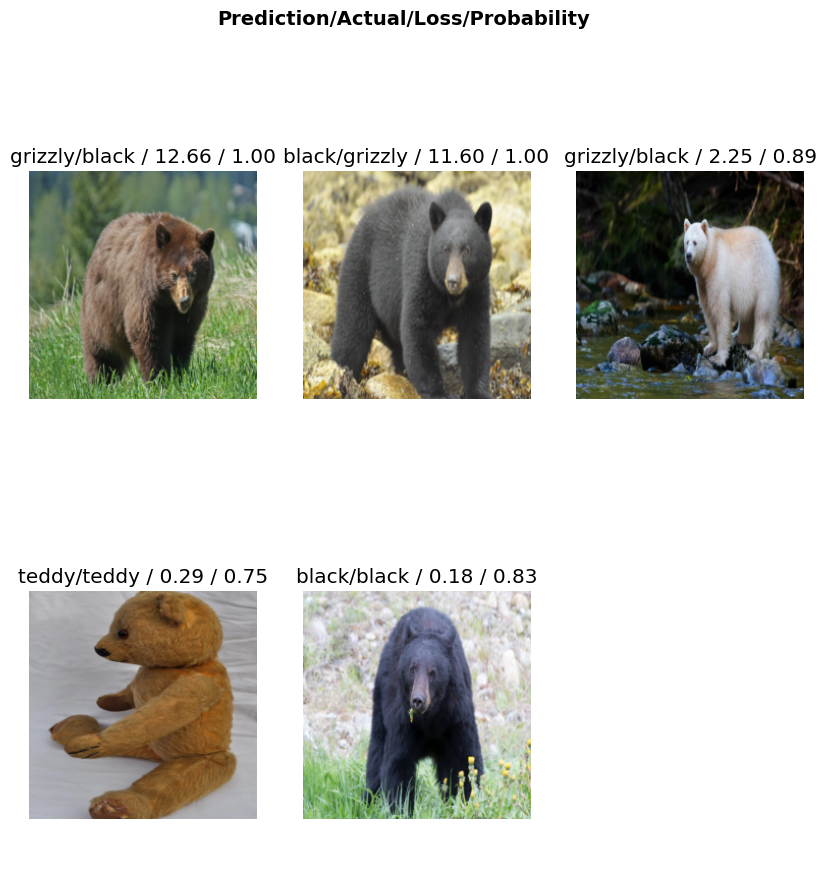

In [ ]:
interp.plot_top_losses(5, nrows=2, figsize=(10, 10))

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): 
    shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export('bears.pkl')

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('bears.pkl')]

In [ ]:
learn_inf = load_learner(path/'bears.pkl')

In [ ]:
learn_inf.predict('bear_images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([2.1257e-06, 1.0000e+00, 2.7545e-08]))

In [ ]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['bear_images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

All together:


In [ ]:
path = Path()
learn_inf = load_learner(path/'bears.pkl')

out_pl = widgets.Output()
btn_upload = widgets.FileUpload()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])